In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from importlib import reload
from scipy import interpolate

In [1]:
#import os
#os.environ['PATH'] += f";C:\\Program Files\\CMake\\bin"

In [2]:
import iri2016
alt_km = (80, 1000, 10)
glat, glon = 0., 0.
time = '2003-11-21T12'
result = iri2016.IRI(time, alt_km, glat, glon)
f_Ne = interpolate.interp1d(result.alt_km.values, result.ne.values, kind='quadratic')

In [3]:
file_atmos = './data/profile_VCD_for_scaling_pd.csv'
profile = pd.read_csv(file_atmos)
f_rho = interpolate.interp1d(profile.altitude/1e3, profile.rho, kind='quadratic', bounds_error=False, fill_value=(profile.rho.min(), profile.rho.max()))
f_t = interpolate.interp1d(profile.altitude/1e3, profile.t, kind='quadratic')
f_gamma = interpolate.interp1d(profile.altitude/1e3, profile.gamma, kind='quadratic')

In [ ]:
import ppigrf
from datetime import datetime
lon = np.linspace(-180., 180., 360)  # degrees east
lat = np.linspace(-90., 90., 180) # degrees north
lon, lat = np.meshgrid(lon, lat)
shape_init = lon.shape
lon, lat = lon.ravel(), lat.ravel()
h   = 150.        # kilometers above sea level
date = datetime(2021, 3, 28)

Be, Bn, Bu = ppigrf.igrf(lon, lat, h, date) # returns east, north, up
norm = np.sqrt(Be**2+Bn**2+Bu**2)
#id = 150
#print(Be)
#(Be[0,id]/norm[0,id], Bn[0,id]/norm[0,id], Bu[0,id]/norm[0,id])

In [199]:
Be = Bn = Bu = norm = None
stf = lambda times, t0, std: -2*(1/std)*((times-t0)/std)*np.exp(-((times-t0)/std)**2)
#stf = lambda times, t0, std: np.exp(-((times-t0)/std)**2)
b = np.array([0.007715872734232366, 0.2949380905824151, -0.9554852107864088])
vel = 0.6
f = 1e-1
std = 50.
altitudes = np.linspace(120., 300., 180)
times = np.linspace(100., 600., 600)

lon = np.linspace(-5., 5., 20)  # degrees east
lat = np.linspace(-5, 5, 21) # degrees north
LON, LAT, ALT = np.meshgrid(lon, lat, altitudes)
date = datetime(2021, 3, 28)
Be, Bn, Bu = ppigrf.igrf(LON, LAT, ALT, date) # returns east, north, up
norm = np.sqrt(Be[0,:]**2+Bn[0,:]**2+Bu[0,:]**2)
LON = LAT = None

#ALT, TIMES = np.meshgrid(altitudes, times)
#vel_wave = stf(TIMES, ALT/vel, std)

In [200]:
angle_n = -200.
angle_z = 70.
ke = np.sin(np.radians(angle_n))*np.cos(np.radians(angle_z))
kn = np.cos(np.radians(angle_n))*np.cos(np.radians(angle_z))
kz = np.sin(np.radians(angle_z))
amplification = np.sqrt(f_rho(ALT[:,:,:,None])/f_rho(0.))
#amplification = np.exp(-((ALT[:,:,:,None]-145.)/15.)**2)*1200.+1.
vel_wave = amplification*stf(times[None,None,None,:], ALT[:,:,:,None]/vel, std)
vel_wave_vector = ke*Be[0,:,:,:,None]+kn*Bn[0,:,:,:,None]+kz*Bu[0,:,:,:,None]
vel_wave_vector_e = vel_wave*vel_wave_vector*Be[0,:,:,:,None]
vel_wave_vector_n = vel_wave*vel_wave_vector*Bn[0,:,:,:,None]
vel_wave_vector_z = vel_wave*vel_wave_vector*Bu[0,:,:,:,None]
vel_wave_vector = None

In [201]:
dvel_dz = np.gradient(f_Ne(ALT[:,:,:,None])*vel_wave_vector_z, altitudes, axis=2)
dvel_de = f_Ne(ALT[:,:,:,None])*np.gradient(vel_wave_vector_e, lon, axis=1)
dvel_dn = f_Ne(ALT[:,:,:,None])*np.gradient(vel_wave_vector_n, lat, axis=0)

fig = plt.figure(figsize=(5,5))
grid = fig.add_gridspec(1, 3)

ax = fig.add_subplot(grid[0, 0])
sc = ax.pcolormesh(dvel_dz[:,:,50,100])
ax = fig.add_subplot(grid[0, 1])
sc = ax.pcolormesh(dvel_de[:,:,50,100])
ax = fig.add_subplot(grid[0, 2])
sc = ax.pcolormesh(dvel_dn[:,:,50,100])

dvel = (dvel_dz + dvel_de + dvel_dn)/norm[:,:,:,None]**2

fig = plt.figure(figsize=(5,5))
sc = plt.pcolormesh(dvel[:,:,50,100])


Ne = Ne_z =  None
Ne = np.zeros_like(dvel)
Ne_z = np.zeros_like(dvel)
dt = times[1]-times[0]
Ne[:,:,:,1:] = np.cumsum((dvel[:,:,:,:-1] + dvel[:,:,:,1:]) / 2 * dt, axis=-1)
Ne_z[:,:,:,1:] = np.cumsum((dvel_dz[:,:,:,:-1] + dvel_dz[:,:,:,1:])/ norm[:,:,:,None]**2 / 2 * dt, axis=-1)
#Ne *= f_Ne(ALT[:,:,:,None])
#Ne_z *= f_Ne(ALT[:,:,:,None])

dvel_dz = dvel_de = dvel_dn = None

dz = altitudes[1] - altitudes[0]
int_Ne = np.trapz(dvel, x=altitudes, axis=2)

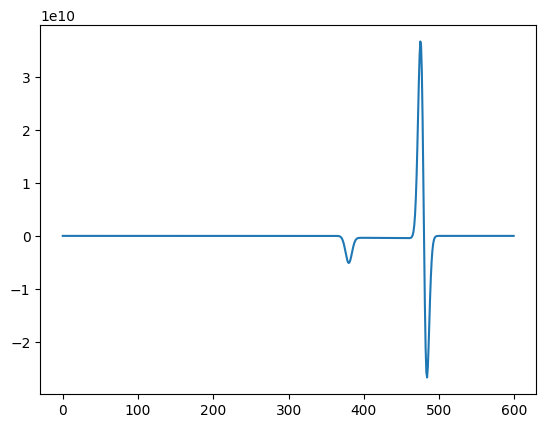

In [197]:
int_Ne.shape
plt.figure()
plt.plot(int_Ne[0,10,:])

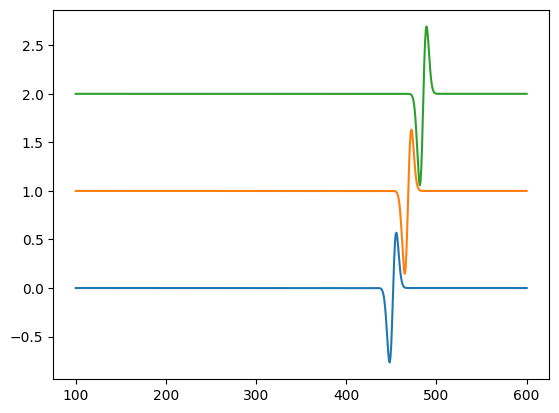

In [196]:
plt.figure()
#sc = plt.pcolormesh(Ne[:,:,50,100])
#sc = plt.pcolormesh(Ne[:,:,50,1].T)
#plt.colorbar(sc)
#plt.plot(times, dvel[0,0,100,:])
#test = np.zeros_like(times)
#test[1:] = np.cumsum(((dvel[0,0,100,:-1] + dvel[0,0,100,1:]) / 2) * dt, axis=-1)
#dvel_test = -2*(1./30.)*((times-300)/30.)*np.exp(-((times-300)/30.)**2)
#test[1:] = np.cumsum(((dvel_test[:-1] + dvel_test[1:]) / 2) * dt,)
#plt.figure()
id_lon = 19
id_lat = 0
id_alt = 170
for ii_plot, ii in enumerate(np.arange(150, 180, 10)): 
#for ii_plot, ii in enumerate(np.arange(0, 20, 2)):   

    one_unknown = 'alt'
    id_alt = ii
    #plt.plot(times, ii_plot+int_Ne[id_lat,id_lon,:]/int_Ne[:,:,:].max(), label=one_unknown)
    plt.plot(times, ii_plot+Ne[id_lat,id_lon,id_alt,:]/Ne[:,:,:,:].max(), label=one_unknown)
    #plt.plot(times, ii_plot+Ne_z[id_lat,id_lon,id_alt,:]/Ne[:,:,:,:].max(), label=one_unknown, linestyle='--')
    #plt.plot(times, ilat+Ne[ilat,id_lon,id_alt,:]/Ne[:,:,:,:].max()-Ne_z[ilat,id_lon,id_alt,:]/Ne[:,:,:,:].max(), label=one_lat, linestyle='--')
#plt.plot(times, dvel[0,0,100,:])
#plt.title(dvel[0,0,100,-1]-dvel[0,0,100,0])

In [ ]:
# Compute the FFT of the signal
#f = stf(times, altitudes[50]/vel, std)
f=Ne[0,0,50,:]
fft_values = np.fft.fft(f)
n = len(f)  # number of samples

# Frequency array (corresponding to the FFT values)
sampling_rate = 1 / (times[1] - times[0])  # compute the sampling rate (assumes uniform spacing)
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)

# Only take the positive frequencies and corresponding FFT values
positive_frequencies = frequencies[:n//2]
positive_fft_values = np.abs(fft_values[:n//2])

idmax = positive_fft_values.argmax()
f = positive_frequencies[idmax]

ke, kn, kz = 0., 0., 2*np.pi*f/vel
positive_fft_values.max()*2*np.pi*f/(f_Ne(altitudes[50])*(1/norm[0,0,50]**2)*Bu[0,0,0,50]*(ke*Be[0,0,0,50]+kn*Bn[0,0,0,50]+kz*Bu[0,0,0,50]))

In [ ]:
# Compute the FFT of the signal
f = stf(times, altitudes[50]/vel, std)
fft_values = np.fft.fft(f)
n = len(f)  # number of samples

# Frequency array (corresponding to the FFT values)
sampling_rate = 1 / (times[1] - times[0])  # compute the sampling rate (assumes uniform spacing)
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)

# Only take the positive frequencies and corresponding FFT values
positive_frequencies = frequencies[:n//2]
positive_fft_values = np.abs(fft_values[:n//2])

idmax = positive_fft_values.argmax()
print(f'f={positive_frequencies[idmax]:.2f} - val={positive_fft_values.max()}')

plt.figure(figsize=(8, 4))
plt.plot(positive_frequencies, positive_fft_values)

In [ ]:
plt.figure()
#plt.pcolormesh(Ne[:,:, 1, 200])
plt.pcolormesh(Ne[5, :, 50, :], vmin=Ne.min(), vmax=Ne.max())

In [ ]:
plt.figure()
sc = plt.pcolormesh(lon.reshape(shape_init), lat.reshape(shape_init), (Be/norm)[0,:].reshape(shape_init))
plt.colorbar(sc)

## Profiles

In [4]:
alts = np.linspace(90., 120., 1000)
alts_dayglow = np.linspace(90., 150., 1000)
times = np.linspace(0., 400., 2000)
ALTS, TIMES = np.meshgrid(alts, times)
ALTS_DAYGLOW, TIMES_DAYGLOW = np.meshgrid(alts_dayglow, times)
dz = alts[1]-alts[0]

In [5]:
file_airglow = './data/VER_profile_scaled.csv'
VER = pd.read_csv(file_airglow)
VER.columns=['VER', 'alt']
#VER.loc[:,'VER'] *= 1e11
#VER.to_csv(file_airglow.replace('.csv', '_scaled.csv'), index=False)
f_VER = interpolate.interp1d(VER.alt, VER.VER, kind='quadratic', bounds_error=False, fill_value=0.)

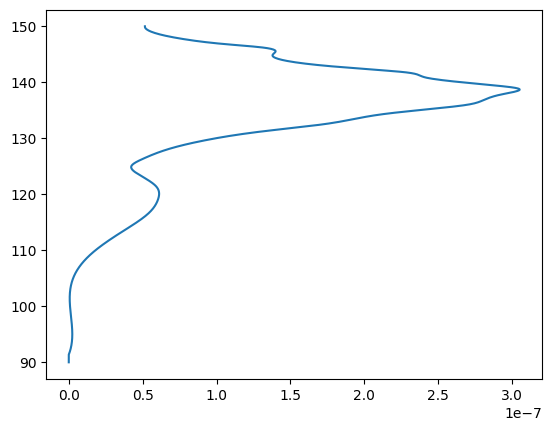

In [6]:
file_airglow = './data/VER_profile_dayglow.csv'
VER = pd.read_csv(file_airglow)
VER.columns=['VER', 'alt']
VER.to_csv(file_airglow.replace('.csv', '_scaled.csv'), index=False)
f_VER_dayglow = interpolate.interp1d(VER.alt, VER.VER, kind='cubic', bounds_error=False, fill_value=(VER.VER.iloc[0], VER.VER.iloc[-1]))

plt.figure()
plt.plot(f_VER_dayglow(alts_dayglow), alts_dayglow)

In [7]:
file_atmos = './data/profile_VCD_for_scaling_pd.csv'
profile = pd.read_csv(file_atmos)
f_rho = interpolate.interp1d(profile.altitude/1e3, profile.rho, kind='quadratic')
f_t = interpolate.interp1d(profile.altitude/1e3, profile.t, kind='quadratic')
f_gamma = interpolate.interp1d(profile.altitude/1e3, profile.gamma, kind='quadratic')
f_c = interpolate.interp1d(profile.altitude/1e3, profile.c, kind='quadratic')

## Nightglow

In [12]:
from tqdm import tqdm

tau = 0.5*1e4 # s, after eq. 23 in Lognonne, 2016
surface_amplitude = 1. # m/s, at airglow altitude
c = 200 # km/s
z0 = 90.
amplification = np.sqrt(f_rho(z0)/f_rho(alts))
Az = surface_amplitude*amplification
#dzAz = np.r_[0., np.diff(Az) / dz]
dzAz = np.gradient(Az, alts)
dzAz = interpolate.interp1d(alts, dzAz, kind='quadratic', bounds_error=False, fill_value=0.)

periods = np.linspace(1., 50., 20)
maxs = []
#plt.figure()
for period in tqdm(periods):
    std_t = period/2.
    t0 = 3*std_t
    #f0 = np.exp(-((times-t0)/std_t)**2)
    f0 = -2*(1/std_t)*((times-t0)/std_t)*np.exp(-((times-t0)/std_t)**2)
    #f0 = np.sin(2*np.pi*times/period)
    f0 = interpolate.interp1d(times, f0, kind='quadratic', bounds_error=False, fill_value=0.)
    #df0dt = -2*(1/std_t)*((times-t0)/std_t)*np.exp(-((times-t0)/std_t)**2)
    #df0dt = np.r_[0., np.diff(f0(times)) / dz]
    df0dt = np.gradient(f0(times), times)
    df0dt = interpolate.interp1d(times, df0dt, kind='quadratic', bounds_error=False, fill_value=0.)

    dVER = -(tau/(1+1*(2*np.pi/period)*tau)) * f_VER(ALTS) * (-(1/c)*df0dt(TIMES-(ALTS-alts.min())*1e3/c)*Az + dzAz(ALTS)*f0(TIMES-(ALTS-alts.min())*1e3/c))
    sig = np.trapz((dVER), x=alts, axis=1)/np.trapz(f_VER(alts), x=alts,)
    #plt.plot(sig)
    max_val_SNR = abs(sig).max()
    maxs.append(max_val_SNR)
#dVER = dVER.real

100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


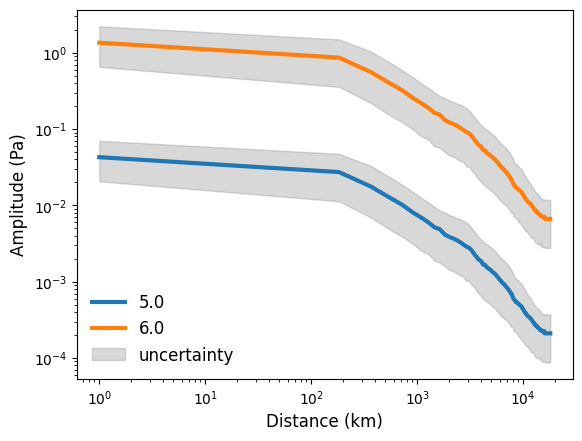

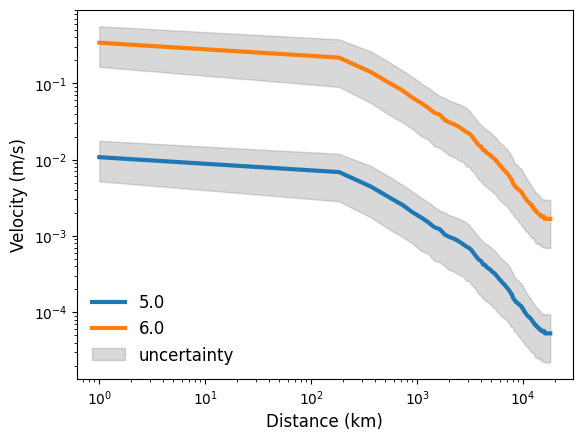

In [9]:
import proba_modules as pm
reload(pm)
file_curve = './data/GF_Dirac_1Hz_all_wfreq.csv'
freq = 0.14
TL_new_p, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, freq, dist_min=100., rho0=f_rho(0.), rhob=f_rho(90.), use_savgol_filter=True, plot=True, scalar_moment=10e6, unknown='pressure')
TL_new_v, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, freq, dist_min=100., rho0=f_rho(0.), rhob=f_rho(90.), cb=f_c(90.), use_savgol_filter=True, plot=True, scalar_moment=10e6, unknown='velocity')

In [10]:
alt_balloon = 90.
rho_c, c_b = f_rho(alt_balloon), f_c(alt_balloon)
beta = 1.
distances = np.arange(10000, np.pi*R0/1.001, 5e5)[:]/1e3
m0 = 5.
photons_nightglow = 2e4
boost_SNR = 50.

plt.figure()
for alpha in maxs:
    amp_a = (beta*alpha)*TL_new_v(distances, m0)*boost_SNR*np.sqrt(photons_nightglow)
    plt.plot(distances, amp_a)
amp_p = TL_new_p(distances, m0)/1e-2
plt.plot(distances, amp_p, ls='--')
plt.yscale('log')

NameError: name 'R0' is not defined

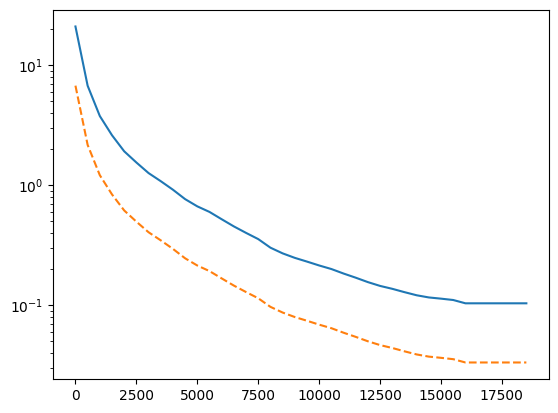

In [264]:
alt_balloon = 90.
rho_c, c_b = f_rho(alt_balloon), f_c(alt_balloon)
beta = 1.
alpha = 1e-5
distances = np.arange(10000, np.pi*R0/1.001, 5e5)[:]/1e3
m0s = [ 6.]
sigma_airglow = np.trapz(VER.VER, x=VER.alt.values,)/np.sqrt(photons_dayglow)

file_airglow = './data/scaling_distance_dayglow.csv'
scaling = pd.read_csv(file_airglow, header=[0])
f_airglow = interpolate.interp1d(scaling.distance, scaling.SNR, kind='quadratic', bounds_error=False, fill_value=(scaling.SNR.iloc[0], scaling.SNR.iloc[-1]))

plt.figure()
for m0 in m0s:
    amp_a = (beta*alpha)*TL_new_v(distances, m0)/sigma_airglow
    #amp_a = f_airglow(distances)
    amp_p = TL_new_p(distances, m0)/1e-2
    plt.plot(distances, amp_a)
    plt.plot(distances, amp_p, ls='--')
plt.yscale('log')

In [35]:
R0 = 6052000
distances = np.linspace(0., np.pi*R0/1.001, 300)/1e3
photons_dayglow = 3.5e5
alpha_dayglow = 1e-5
photons_nightglow = 2e4
boost_SNR = 1.
beta = 1.
m0 = 7.

file_airglow = './data/VER_profile_dayglow.csv'
VER = pd.read_csv(file_airglow)
VER.columns=['VER', 'alt']
sigma_airglow_dayglow = np.trapz(VER.VER, x=VER.alt.values,)/(np.sqrt(photons_dayglow)*boost_SNR)
scaling = (beta*alpha_dayglow)*TL_new_v(distances, m0)/sigma_airglow_dayglow
airglow_scaling = pd.DataFrame(np.c_[distances, scaling], columns=['distance', 'SNR'])
airglow_scaling.to_csv('./data/scaling_distance_dayglow.csv', header=True, index=False)

sigma_airglow_nightglow = 1./(np.sqrt(photons_nightglow)*boost_SNR)
airglow_scaling_all = pd.DataFrame()
for period, alpha_nightglow in zip(periods, maxs):
    scaling = (beta*alpha_nightglow)*TL_new_v(distances, m0)/sigma_airglow_nightglow
    airglow_scaling = pd.DataFrame(np.c_[distances, scaling], columns=['distance', 'SNR'])
    airglow_scaling['period'] = period
    airglow_scaling_all = pd.concat([airglow_scaling_all, airglow_scaling])
airglow_scaling_all.reset_index(drop=True, inplace=True)
airglow_scaling_all.to_csv('./data/scaling_distance_nightglow.csv', header=True, index=False)

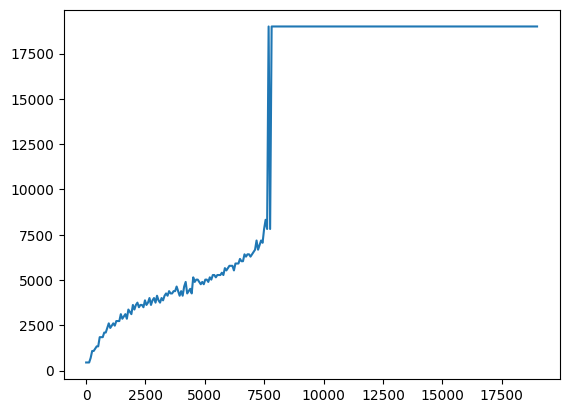

In [36]:
def get_airglow_scaling(TL_new, period, file_scaling, R0=6052000, sigma_balloon=1e-2, boost_SNR=1., m0=7.,):

    scaling = pd.read_csv(file_scaling, header=[0])
    if 'period' in scaling.columns:
        diff = abs(scaling.period-period)
        scaling = scaling.loc[diff==diff.min()]
    f_airglow = interpolate.interp1d(scaling.distance, scaling.SNR, kind='nearest', bounds_error=False, fill_value=(scaling.SNR.iloc[0], scaling.SNR.iloc[-1]))

    distances = np.linspace(0., np.pi*R0/1.001, 300)/1e3
    distances_r0 = np.linspace(-np.pi*R0/1.001, np.pi*R0/1.001, 300)/1e3
    DIST, DIST_R0 = np.meshgrid(distances, distances_r0)

    diff = abs(TL_new(DIST+DIST_R0, m0)/sigma_balloon-boost_SNR*f_airglow(DIST))
    flipped_diff = np.flip(diff, axis=0)
    flipped_indices = flipped_diff.argmin(axis=0) ## In order to get argmin to return the largest index if multiple minima
    original_indices = diff.shape[0] - 1 - flipped_indices
    #original_indices = diff.argmin(axis=0)
    coefs = distances_r0[original_indices]
    f_r0 = interpolate.interp1d(distances, coefs, bounds_error=False, fill_value=(coefs[0], coefs[-1]))

    return f_r0

R0=6052000
file_scaling = './data/scaling_distance_dayglow.csv'
file_scaling = './data/scaling_distance_nightglow.csv'
period = 25.
distances = np.linspace(0., np.pi*R0/1.001, 300)/1e3
f_r0 = get_airglow_scaling(TL_new_p, period, file_scaling, R0=6052000, sigma_balloon=1e-2, boost_SNR=50.)

plt.figure()
plt.plot(distances, f_r0(distances))

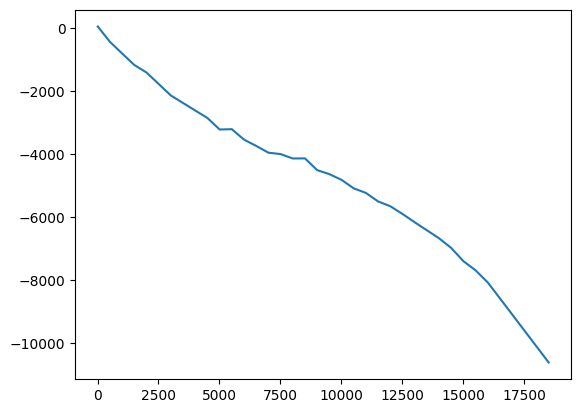

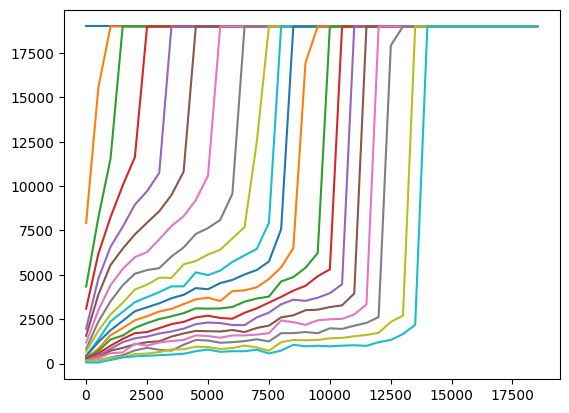

In [33]:
def get_airglow_scaling(TL_new_v, TL_new_p, R0=6052000, sigma_balloon=1e-2, sigma_airglow=1e-1, m0=7., beta=1., alpha = 1e-5):

    distances = np.linspace(0., np.pi*R0/1.001, 300)/1e3
    distances_r0 = np.linspace(-np.pi*R0/1.001, np.pi*R0/1.001, 300)/1e3
    DIST, DIST_R0 = np.meshgrid(distances, distances_r0)

    diff = abs(TL_new_p(DIST+DIST_R0, m0)/sigma_balloon-(beta*alpha)*TL_new_v(DIST, m0)/sigma_airglow)
    flipped_diff = np.flip(diff, axis=0)
    flipped_indices = flipped_diff.argmin(axis=0) ## In order to get argmin to return the largest index if multiple minima
    original_indices = diff.shape[0] - 1 - flipped_indices
    #original_indices = diff.argmin(axis=0)
    coefs = distances_r0[original_indices]
    f_r0 = interpolate.interp1d(distances, coefs, kind='linear', bounds_error=False, fill_value=(coefs[0], coefs[-1]))

    return f_r0

file_airglow = './data/VER_profile_dayglow.csv'
VER = pd.read_csv(file_airglow)
VER.columns=['VER', 'alt']
VER.to_csv(file_airglow.replace('.csv', '_scaled.csv'), index=False)
boost_SNR = 1
R0=6052000
distances = np.arange(10000, np.pi*R0/1.001, 5e5)[:]/1e3

photons_dayglow = 3.5e5
alpha = 1e-5
sigma_airglow = np.trapz(VER.VER, x=VER.alt.values,)/(np.sqrt(photons_dayglow)*boost_SNR)
f_r0 = get_airglow_scaling(TL_new_v, TL_new_p, R0=6052000, sigma_balloon=1e-2, sigma_airglow=sigma_airglow, beta=1., alpha = alpha)
airglow_scaling = pd.DataFrame(np.c_[distances, f_r0(distances)], columns=['distance', 'scaling'])
airglow_scaling.to_csv('./data/scaling_distance_dayglow.csv', header=True, index=False)

plt.figure()
plt.plot(airglow_scaling.distance, airglow_scaling.scaling)

photons_nightglow = 2e4
sigma_airglow = 1./(np.sqrt(photons_nightglow)*boost_SNR)
#alt_balloon = 90.
#rho_c, c_b = f_rho(alt_balloon), f_c(alt_balloon)
airglow_scaling_all = pd.DataFrame()
for period, alpha in zip(periods, maxs):
    boost_SNR = 50.
    f_r0 = get_airglow_scaling(TL_new_v, TL_new_p, R0=6052000, sigma_balloon=1e-2, sigma_airglow=sigma_airglow, beta=1., alpha = alpha*boost_SNR)
    airglow_scaling = pd.DataFrame(np.c_[distances, f_r0(distances)], columns=['distance', 'scaling'])
    airglow_scaling['period'] = period
    airglow_scaling_all = pd.concat([airglow_scaling_all, airglow_scaling])
airglow_scaling_all.reset_index(drop=True, inplace=True)
airglow_scaling_all.to_csv('./data/scaling_distance_nightglow.csv', header=True, index=False)

plt.figure()
for period, airglow_scaling in airglow_scaling_all.groupby('period'):
    plt.plot(airglow_scaling.distance, airglow_scaling.scaling)

<Figure size 640x480 with 0 Axes>

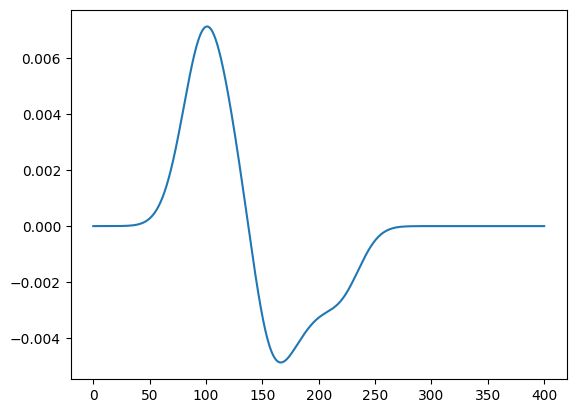

In [27]:
df0dt = None
f0 = None
time_to_airglow = 0#90./0.6
background = 0.5

plt.figure()
#sc = plt.pcolormesh(times+time_to_airglow, alts, (abs(dVER).T/f_VER(ALTS).T)/background, levels=[1e-3, 1e-2, 0.1])
#plt.plot(times, f0)
#plt.plot(times, df0dt(times))
#plt.plot(alts, dzAz(alts))
#plt.plot(alts, f_rho(alts))
#plt.yscale('log')
#plt.colorbar(sc)

plt.figure()
plt.plot(times, -np.trapz((dVER), x=alts, axis=1)/np.trapz(f_VER(alts), x=alts,))
#plt.axhline(np.trapz(f_VER(alts), x=alts,))

## Photons

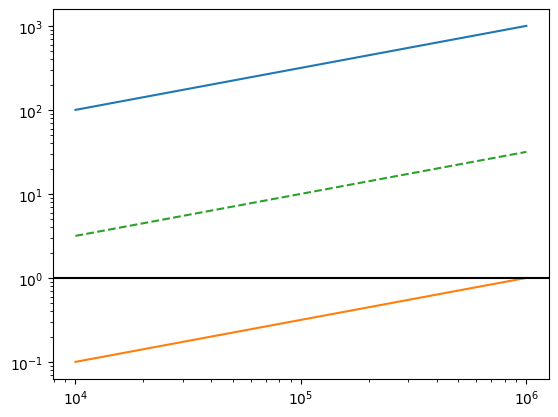

In [144]:
photons = np.linspace(1e4, 1e6, 100)
int_time = 10.
n_bins = 10
boost_SNR = np.sqrt(int_time)*n_bins
pert_perc = 1e-3

plt.figure()
plt.plot(photons, photons/np.sqrt(photons))
plt.plot(photons, pert_perc*photons/np.sqrt(photons))
plt.plot(photons, pert_perc*boost_SNR*photons/np.sqrt(photons), ls='--')
plt.axhline(1., color='black')
plt.xscale('log')
plt.yscale('log')

In [28]:
background_radiance_nightglow = 1.6e15
factor_radiance_to_pix = 2e4/background_radiance_nightglow
radiance = np.trapz((dVER), x=alts*1e3, axis=1)
n_for_binning = 5
photons_signal = radiance.max()*factor_radiance_to_pix*n_for_binning
photons_background = np.sqrt(np.trapz(f_VER(alts), x=alts*1e3,)*factor_radiance_to_pix)
photons_signal/photons_background

6.544445140380036

## Dayglow

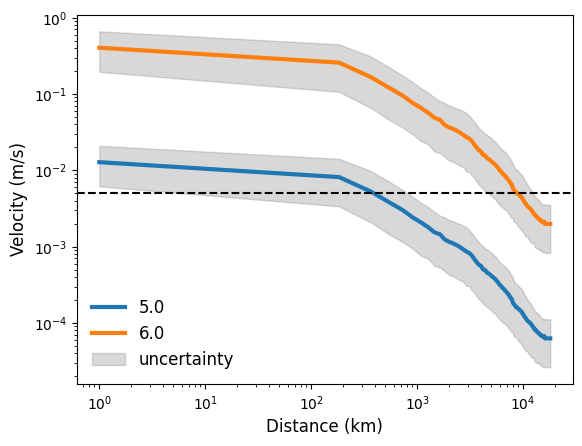

In [136]:
import proba_modules as pm
reload(pm)
file_curve = './data/GF_Dirac_1Hz_all_wfreq.csv'
#pd_all_amps = pd.read_csv(file_curve, header=[0])
#freqs = pd_all_amps.fmax.unique()
#pd_all_amps_freq = pd_all_amps.loc[pd_all_amps.fmax==freqs[2]]
freq = 0.14
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, freq, dist_min=100., rho0=f_rho(0.), rhob=f_rho(90.), use_savgol_filter=True, plot=True, scalar_moment=10e6, unknown='pressure')
plt.axhline(5e-3, color='black', ls='--')

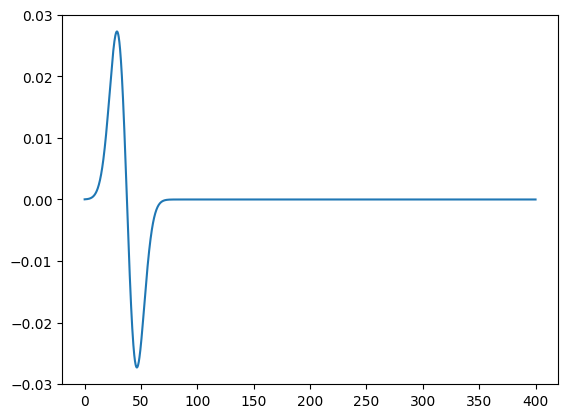

In [138]:
alpha = 1e-2
period = 25.
surface_amplitude = 1e-1*period/(2*np.pi) # m/s, at minimum airglow altitude
c = 250 # km/s
z0 = 90.

#amplification = np.sqrt(f_rho(z0)/f_rho(alts_dayglow))
amplification = np.exp(-((alts_dayglow-145.)/10.)**2)*1200.+1.
Az = surface_amplitude*amplification
Az = interpolate.interp1d(alts_dayglow, Az, kind='quadratic', bounds_error=False, fill_value=0.)
dzAz = np.gradient(Az(alts_dayglow), alts_dayglow)
dzAz = interpolate.interp1d(alts_dayglow, dzAz, kind='quadratic', bounds_error=False, fill_value=0.)
std_t = period/2.
t0 = 3*std_t
f0 = -2*(1/std_t)*((times-t0)/std_t)*np.exp(-((times-t0)/std_t)**2)
#f0 = np.exp(-((times-t0)/std_t)**2) # Conversion to displacement
f0 = interpolate.interp1d(times, f0, kind='quadratic', bounds_error=False, fill_value=0.)
df0dt = np.gradient(f0(times), times)
df0dt = interpolate.interp1d(times, df0dt, kind='quadratic', bounds_error=False, fill_value=0.)

#z = np.polyfit(alts_dayglow, f_VER_dayglow(alts_dayglow), 12)
#p = np.poly1d(z)
dVERdz = np.gradient(f_VER_dayglow(alts_dayglow), alts_dayglow)
dVERdz = interpolate.interp1d(alts_dayglow, dVERdz, kind='quadratic', bounds_error=False, fill_value=(0., dVERdz[-1]))


plt.figure()
plt.plot(times, f0(times)*Az(alts[0]))

dVER_ad = alpha*(1.-f_gamma(ALTS_DAYGLOW))*f_t(ALTS_DAYGLOW)*f_VER_dayglow(ALTS_DAYGLOW)*(-(1/c)*df0dt(TIMES_DAYGLOW-(ALTS_DAYGLOW-alts_dayglow.min())*1e3/c)*Az(ALTS_DAYGLOW) + dzAz(ALTS_DAYGLOW)*f0(TIMES_DAYGLOW-(ALTS_DAYGLOW-alts_dayglow.min())*1e3/c))
dVER_tr = -f0(TIMES_DAYGLOW-(ALTS_DAYGLOW-alts_dayglow.min())*1e3/c)*Az(ALTS_DAYGLOW)*dVERdz(ALTS_DAYGLOW)

In [196]:
abs(np.trapz((dVER_ad+1*dVER_tr), x=alts_dayglow, axis=1)).max()/surface_amplitude

4.645314900762182e-06

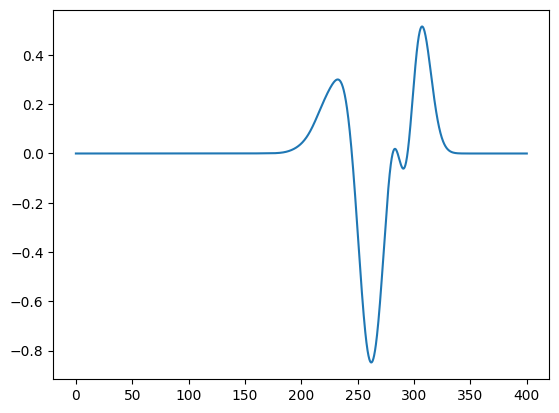

In [129]:
plt.figure()
plt.plot(times, -np.trapz((dVER_ad+1*dVER_tr), x=alts_dayglow, axis=1)/np.trapz(f_VER_dayglow(alts_dayglow), x=alts_dayglow,))

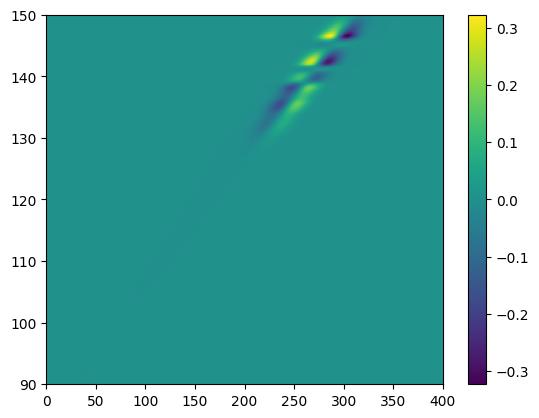

In [130]:
plt.figure()
sc = plt.pcolormesh(times, alts_dayglow, (dVER_ad+1*dVER_tr).T/np.trapz(f_VER_dayglow(alts_dayglow), x=alts_dayglow,))
#sc = plt.pcolormesh(times, alts_dayglow, (f0(TIMES_DAYGLOW-(ALTS_DAYGLOW-alts_dayglow.min())*1e3/c)).T)
plt.colorbar(sc)

C:\Users\quentin\AppData\Local\Temp\ipykernel_18468\2790894516.py:11: RuntimeWarning: overflow encountered in exp
  attenuation = np.exp(-np.cumsum(alpha_att*dz))
C:\Users\quentin\AppData\Local\Temp\ipykernel_18468\2790894516.py:12: RuntimeWarning: overflow encountered in multiply
  return attenuation*amplification


[3.80936584e-189 4.13392839e+002]


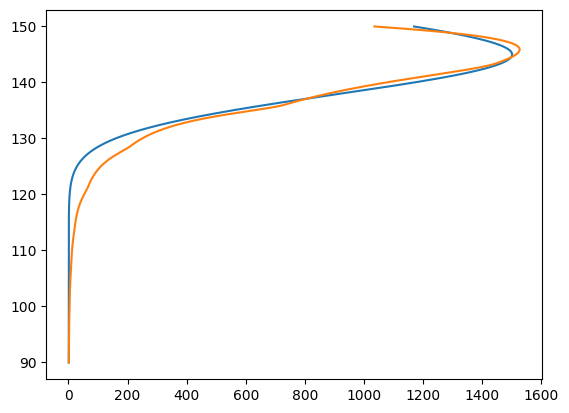

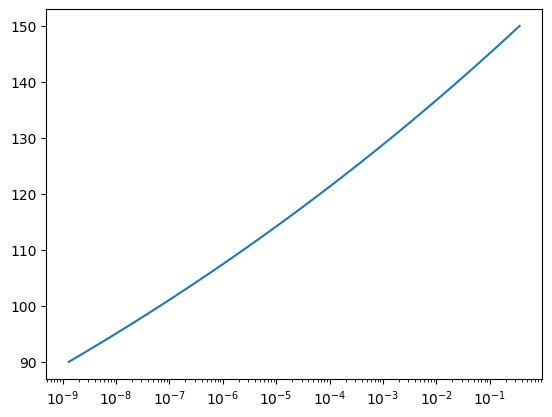

In [124]:
from scipy.optimize import curve_fit

amplification = np.sqrt(f_rho(z0)/f_rho(alts_dayglow))
dz = alts_dayglow[1]-alts_dayglow[0]

def call_alpha(x, a, b):
    return a*np.exp(b*(x/x.min())**0.09)

def func(x, a, b):
    alpha_att = call_alpha(x, a, b)
    attenuation = np.exp(-np.cumsum(alpha_att*dz))
    return attenuation*amplification

best_profile = np.exp(-((alts_dayglow-145.)/10.)**2)*1500.+1.
popt, pcov = curve_fit(func, alts_dayglow, best_profile, p0=[1e-3, 2.5], maxfev=50000,)
print(popt)

plt.figure()
plt.plot(best_profile, alts_dayglow)
plt.plot(func(alts_dayglow, *popt), alts_dayglow)
#plt.xscale('log')

plt.figure()
plt.plot(call_alpha(alts_dayglow, *popt), alts_dayglow)
plt.xscale('log')

In [ ]:
plt.figure()
amplification = np.sqrt(f_rho(z0)/f_rho(alts_dayglow))
alpha_att = 1e-3*np.exp(2.5*alts_dayglow/alts_dayglow.min())
attenuation = np.exp(-np.cumsum(alpha_att*dz))
plt.plot(attenuation*amplification, alts_dayglow)